#### Import Data

In [1]:
import pandas as pd

data_file_path = '../../data'

train_df = pd.read_csv(f'{data_file_path}/train_data.csv', index_col=0)
test_df = pd.read_csv(f'{data_file_path}/test_data.csv', index_col=0)

# drop 's' column

train_df = train_df.copy().drop(columns='s')
test_df = test_df.copy().drop(columns='s')

#### Partial Least Squares

In [2]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=3,
                    scale=True,
                    max_iter=500,
                    tol=1e-9,
                    copy=True)

pls.fit(X=train_df.copy().drop(columns='y'), y=train_df['y'])

# Use the fitted model to make predictions
y_pred = pls.predict(test_df.copy().drop(columns='y'))

In [3]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [4]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, f1_score

# Calculate metrics
cm = confusion_matrix(test_df['y'], y_pred)
recall = recall_score(test_df['y'], y_pred)
precision = precision_score(test_df['y'], y_pred)
accuracy = accuracy_score(test_df['y'], y_pred)
f1 = f1_score(test_df['y'], y_pred)

In [5]:
import numpy as np
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(test_df['y'])), replace=True)
    y_true_resampled = test_df['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
metrics_table = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

# Display the table
metrics_table

Recall CI: [0.6875 1.    ]
Precision CI: [0.67966667 1.        ]
Accuracy CI: [0.67647059 0.94117647]
F1 Score CI: [0.71794872 0.95652174]


,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.857143,0.687500,1.000000
1,Precision/Specificity,0.857143,0.679667,1.000000
2,Accuracy,0.823529,0.676471,0.941176
3,F1 Score,0.857143,0.717949,0.956522


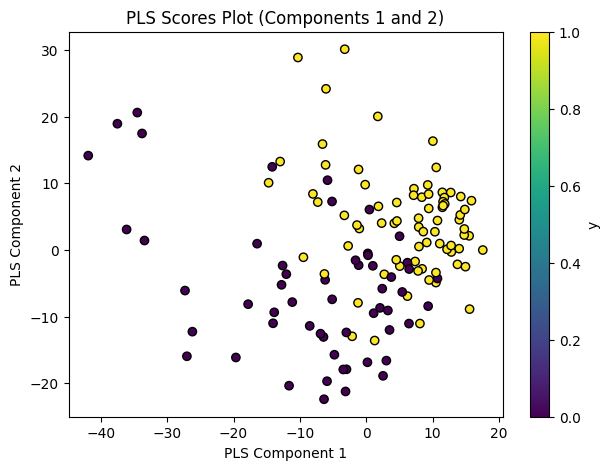

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the PLS scores (X-scores)
X_scores = pls.x_scores_  # shape: (n_samples, n_components)

# Let's pick the first two components for 2D visualization
comp1 = X_scores[:, 0]
comp2 = X_scores[:, 1]

# If you'd like to color the samples by their true y values:
y_values = train_df['y'].values

# Scatter plot
plt.figure(figsize=(7, 5))
scatter = plt.scatter(comp1, comp2, c=y_values, cmap='viridis', edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot (Components 1 and 2)')

# Optional colorbar if y is continuous or numeric
plt.colorbar(scatter, label='y')

plt.show()

Shape of x_loadings: (3350, 3)
Loadings for component 1: [ 0.00058008  0.00916863 -0.00695435 ... -0.00384542  0.01085614
  0.00847642]
Loadings for component 2: [-0.01194784 -0.01769042 -0.00385303 ... -0.01089495 -0.00465932
  0.02052755]


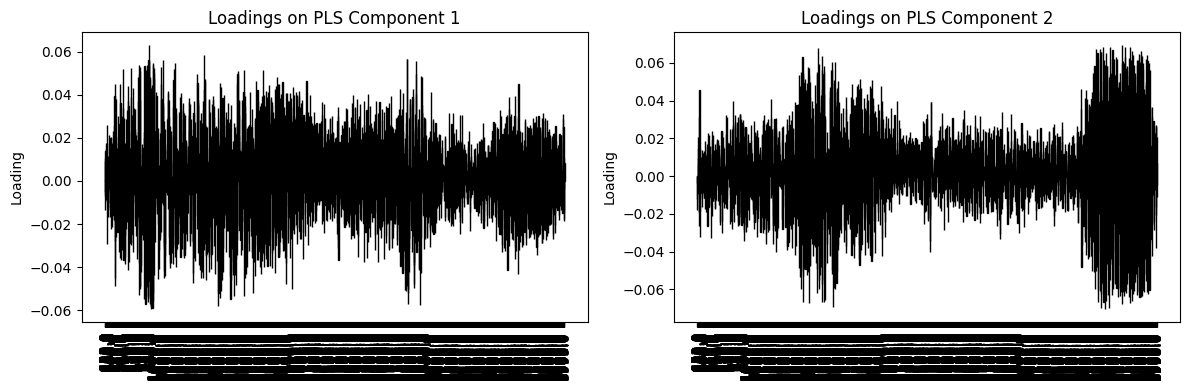

In [7]:
x_loadings = pls.x_loadings_  # shape: (n_features, n_components)

print("Shape of x_loadings:", x_loadings.shape)
print("Loadings for component 1:", x_loadings[:, 0])
print("Loadings for component 2:", x_loadings[:, 1])

# Suppose your original features are in train_df.columns.drop('y')
feature_names = train_df.columns.drop('y')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(len(feature_names)), x_loadings[:, 0], color='skyblue', edgecolor='k')
axes[0].set_xticks(range(len(feature_names)))
axes[0].set_xticklabels(feature_names, rotation=90)
axes[0].set_title('Loadings on PLS Component 1')
axes[0].set_ylabel('Loading')

axes[1].bar(range(len(feature_names)), x_loadings[:, 1], color='lightgreen', edgecolor='k')
axes[1].set_xticks(range(len(feature_names)))
axes[1].set_xticklabels(feature_names, rotation=90)
axes[1].set_title('Loadings on PLS Component 2')
axes[1].set_ylabel('Loading')

plt.tight_layout()
plt.show()

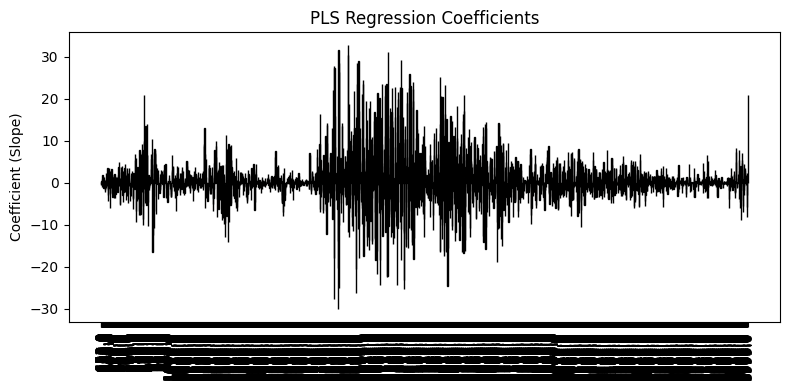

In [8]:
# 1) Extract the final regression coefficients (slopes) from the PLS model
coefs = pls.coef_.ravel()  # shape (n_features,)

# 2) Get the feature names (assuming train_df has columns for your predictors + 'y')
feature_names = train_df.columns.drop('y')

# 3) Make a bar plot of the regression coefficients
plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_names)), coefs, color='skyblue', edgecolor='k')
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.ylabel('Coefficient (Slope)')
plt.title('PLS Regression Coefficients')
plt.tight_layout()
plt.show()

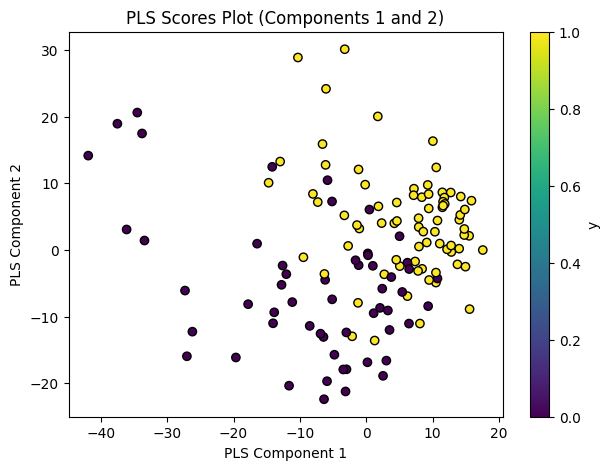

In [9]:
import matplotlib.pyplot as plt

# Extract the PLS scores (X-scores)
X_scores = pls.x_scores_  # shape: (n_samples, n_components)

# Let's pick the first two components for 2D visualization
comp1 = X_scores[:, 0]
comp2 = X_scores[:, 1]

# If you'd like to color the samples by their true y values:
y_values = train_df['y'].values

# Scatter plot
plt.figure(figsize=(7, 5))
scatter = plt.scatter(comp1, comp2, c=y_values, cmap='viridis', edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot (Components 1 and 2)')

# Optional colorbar if y is continuous or numeric
plt.colorbar(scatter, label='y')

plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression

# fit a logistic regression to PLS scores to find a decision boundary

lr = LogisticRegression(penalty='l2',
                        dual=False,
                        tol=0.0001,
                        C=1.0,
                        fit_intercept=True,
                        intercept_scaling=1,
                        class_weight=None,
                        random_state=None,
                        solver='lbfgs',
                        max_iter=100,
                        multi_class='deprecated',
                        verbose=0,
                        warm_start=False,
                        n_jobs=None,
                        l1_ratio=None)

y_pred_train = pls.predict(train_df.copy().drop(columns='y'))
lr.fit(X=y_pred_train.reshape(-1,1), y=train_df['y'])

LogisticRegression()

In [11]:
y_pred_pls = pls.predict(test_df.copy().drop(columns='y'))
y_pred = lr.predict(y_pred_pls.reshape(-1,1))

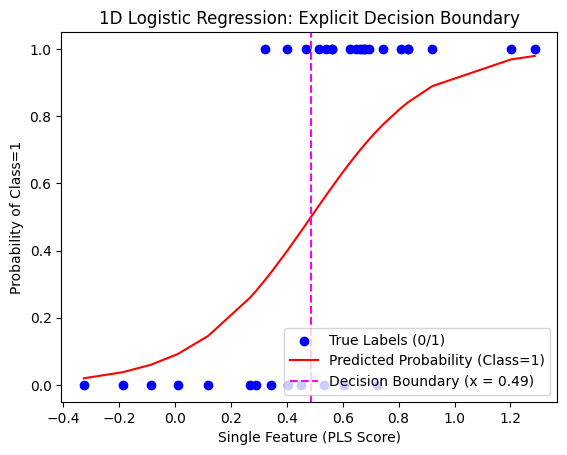

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract your single feature (PLS scores) and true labels
feature = y_pred_pls.reshape(-1)     # shape (n_samples,)
true_labels = test_df['y'].values    # shape (n_samples,)

# 2) Sort by the feature so the logistic curve is plotted smoothly
sorted_indices = np.argsort(feature)
feature_sorted = feature[sorted_indices]
true_labels_sorted = true_labels[sorted_indices]

# 3) Predicted probability of class=1 from the logistic regression
y_prob = lr.predict_proba(feature_sorted.reshape(-1, 1))[:, 1]

# 4) Plot the true labels as a scatter (0 or 1) vs. feature
plt.scatter(feature_sorted, true_labels_sorted,
            label='True Labels (0/1)', color='blue')

# 5) Plot the logistic curve (predicted probability) as a red line
plt.plot(feature_sorted, y_prob,
         color='red', label='Predicted Probability (Class=1)')

# 7) Calculate and plot the vertical decision boundary in feature space
w0 = lr.intercept_[0]        # intercept
w1 = lr.coef_[0, 0]          # coefficient for the single feature
x_boundary = -w0 / w1        # solve w0 + w1*x = 0

plt.axvline(x=x_boundary, color='magenta', linestyle='--',
            label=f"Decision Boundary (x = {x_boundary:.2f})")

# 8) Labels, legend, and show
plt.xlabel('Single Feature (PLS Score)')
plt.ylabel('Probability of Class=1')
plt.title('1D Logistic Regression: Explicit Decision Boundary')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, f1_score

# Calculate metrics
cm = confusion_matrix(test_df['y'], y_pred)
recall = recall_score(test_df['y'], y_pred)
precision = precision_score(test_df['y'], y_pred)
accuracy = accuracy_score(test_df['y'], y_pred)
f1 = f1_score(test_df['y'], y_pred)

In [14]:

import numpy as np
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(test_df['y'])), replace=True)
    y_true_resampled = test_df['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
metrics_table = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

# Display the table
metrics_table

Recall CI: [0.68421053 1.        ]
Precision CI: [0.68421053 1.        ]
Accuracy CI: [0.67647059 0.94117647]
F1 Score CI: [0.72222222 0.95454545]


,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.857143,0.684211,1.000000
1,Precision/Specificity,0.857143,0.684211,1.000000
2,Accuracy,0.823529,0.676471,0.941176
3,F1 Score,0.857143,0.722222,0.954545


### VIP Analysis

In [15]:
import numpy as np

def compute_vip(pls, X):
    """
    Compute the Variable Importance in Projection (VIP) scores for each predictor (wavenumber).

    Parameters
    ----------
    pls : trained PLSRegression object
        A fitted scikit-learn PLSRegression model.
    X : ndarray or pandas dataframe, shape (n_samples, n_features)
        Training data on which the model was fit (or at least the same shape/features).

    Returns
    -------
    vip_scores : ndarray of shape (n_features,)
        VIP score for each feature (wavenumber).
    """
    # Extract the necessary parameters from the PLS model
    T = pls.x_scores_           # (n_samples, n_components)
    W = pls.x_weights_          # (n_features, n_components)
    Q = pls.y_loadings_.ravel() # (n_components,)

    # Number of features and components
    p, A = W.shape

    # Sum of squares explained by each component for Y
    # SS(t_h * q_h) ~ sum over all samples of (t_h * q_h)^2
    # We can do that by (T[:,h] * Q[h])^2 and summing
    SS = np.sum((T * Q)**2, axis=0)  # shape (n_components,)
    total_SS = np.sum(SS)           # total sum of squares

    # Initialize VIP array
    vip_scores = np.zeros(p)

    # For each component h
    for h in range(A):
        # Weight for feature j on component h = W[j,h]
        # Contribution factor = (T[:,h] * Q[h])^2
        # So we add the share of the SS explained by component h, scaled by W[j,h]^2
        vip_scores += (SS[h] * (W[:, h]**2)) / total_SS

    # Multiply by p and take the square root
    vip_scores = np.sqrt(p * vip_scores)
    return vip_scores


In [16]:
# Example: wavenumbers going from 4000 cm^-1 down to 650 cm^-1
# (or the reverse order; you just need to match your data)
wavenumbers = np.linspace(4000, 650, num=train_df.shape[1]-1)

vip = compute_vip(pls, train_df.copy().drop(columns='y'))

In [17]:
def sliding_window_smooth(values, window_size=20):
    """
    Smooth values with a simple moving average over `window_size`.
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(values, kernel, mode='same')

# Smooth VIP with a window of 20 features
window_size = 11
vip_smoothed = sliding_window_smooth(vip, window_size=window_size)



In [18]:
np.mean(train_df.copy().drop(columns='y'), axis=0)

650.0     0.016192
651.0     0.016425
652.0     0.016778
653.0     0.016844
654.0     0.017902
            ...   
3995.0    0.017222
3996.0    0.017299
3997.0    0.017320
3998.0    0.017286
3999.0    0.017261
Length: 3350, dtype: float64

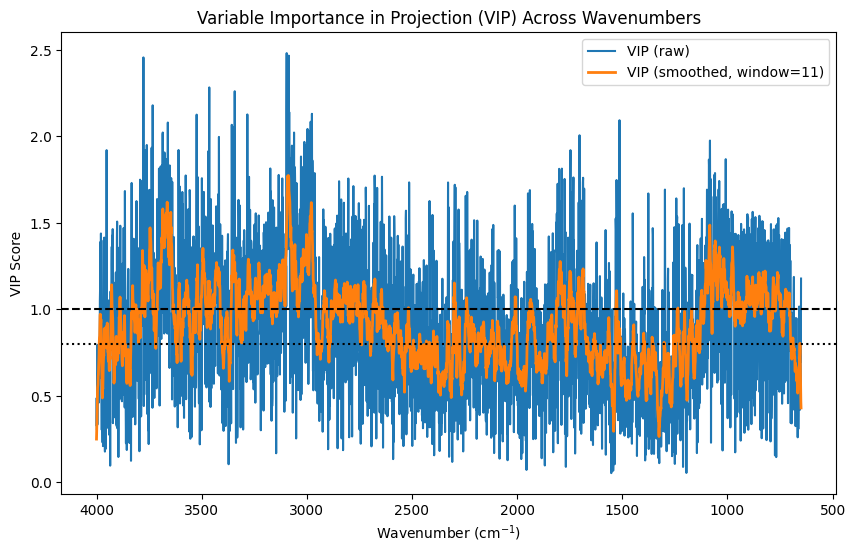

In [19]:
plt.figure(figsize=(10, 6))

plt.plot(wavenumbers, vip, label='VIP (raw)')
plt.plot(wavenumbers, vip_smoothed, label=f'VIP (smoothed, window={window_size})', linewidth=2)
plt.axhline(y=1.0, linestyle='dashed', color='black')
plt.axhline(y=0.8, linestyle='dotted', color='black')

plt.gca().invert_xaxis()  # Often MIR spectra are plotted from high to low wavenumber
plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("VIP Score")
plt.title("Variable Importance in Projection (VIP) Across Wavenumbers")
plt.legend()
plt.show()

C:\Users\cbsit\AppData\Local\Temp\ipykernel_29148\449241534.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


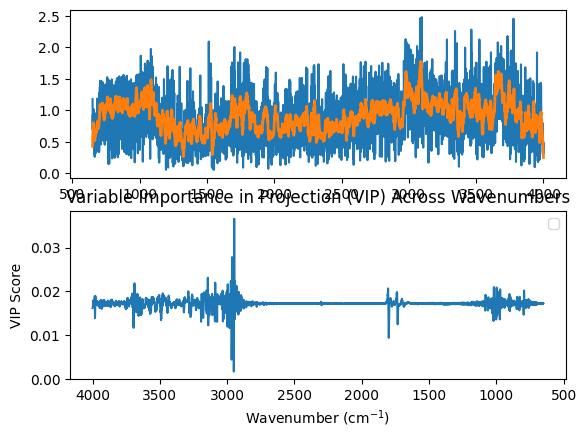

In [20]:
fig, axs = plt.subplots(2)#, sharex=True)

axs[0].plot(wavenumbers, vip, label='VIP (raw)')
axs[0].plot(wavenumbers, vip_smoothed, label=f'VIP (smoothed, window={window_size})', linewidth=2)

axs[1].plot(wavenumbers, np.mean(train_df.copy().drop(columns='y'), axis=0))

plt.gca().invert_xaxis()  # Often MIR spectra are plotted from high to low wavenumber
plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("VIP Score")
plt.title("Variable Importance in Projection (VIP) Across Wavenumbers")
plt.legend()
plt.show()


In [21]:
def subset_dataframe_by_vip(df, feature_cols, vip_scores, threshold=1.0):
    """
    Subset a DataFrame (which may contain extra, non-spectral columns)
    by keeping only those spectral columns whose VIP score is >= threshold,
    while retaining any non-spectral columns.

    Parameters
    ----------
    df : pd.DataFrame
        The entire DataFrame containing both spectral and non-spectral columns.
    feature_cols : list of str
        The column names in df that correspond exactly (and in the same order)
        to the VIP scores.
    vip_scores : array-like of shape (len(feature_cols),)
        The VIP scores for each spectral column in feature_cols.
    threshold : float, optional (default=1.0)
        The VIP threshold. Only spectral columns with VIP >= threshold are kept.

    Returns
    -------
    df_subset : pd.DataFrame
        A DataFrame that:
          - Retains all non-spectral columns from df
          - Keeps only the spectral columns whose VIP >= threshold
    """
    # Convert vip_scores to a NumPy array for easier masking
    vip_scores = np.asarray(vip_scores)

    # Check that feature_cols and vip_scores align in length
    if len(feature_cols) != len(vip_scores):
        raise ValueError(
            f"Number of feature_cols ({len(feature_cols)}) must match "
            f"length of vip_scores ({len(vip_scores)})."
        )

    # Determine which spectral columns pass the VIP threshold
    keep_mask = (vip_scores >= threshold)
    kept_spectral_cols = [col for col, keep in zip(feature_cols, keep_mask) if keep]

    # Collect any columns in df that are NOT in feature_cols (e.g., 'y', IDs, etc.)
    non_spectral_cols = [col for col in df.columns if col not in feature_cols]

    # Final columns to keep = all non-spectral columns + the kept spectral columns
    cols_to_keep = non_spectral_cols + kept_spectral_cols

    # Subset the original df
    df_subset = df[cols_to_keep]

    return df_subset


In [22]:
# Example: Suppose your training DataFrame is train_df
# and we have a separate list of spectral columns we used for the PLS model
# (excluding 'y' or any other extra columns).
feature_cols = [c for c in train_df.columns if c not in ['y']]

# 'vip' is the array of VIP scores computed in exactly that order
# e.g. vip[i] corresponds to feature_cols[i].

df_train_subset = subset_dataframe_by_vip(
    df=train_df,
    feature_cols=feature_cols,
    vip_scores=vip_smoothed,
    threshold=0.8
)

df_test_subset = subset_dataframe_by_vip(
    df=test_df,
    feature_cols=feature_cols,
    vip_scores=vip_smoothed,
    threshold=0.8
)


In [23]:
pls = PLSRegression(n_components=3,
                    scale=True,
                    max_iter=1000,
                    tol=1e-9,
                    copy=True)

pls.fit(X=df_train_subset.copy().drop(columns='y'), y=df_train_subset['y'])
y_pred = pls.predict(df_test_subset.copy().drop(columns='y'))

In [24]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

# Calculate metrics
cm = confusion_matrix(df_test_subset['y'], y_pred)
recall = recall_score(df_test_subset['y'], y_pred)
precision = precision_score(df_test_subset['y'], y_pred)
accuracy = accuracy_score(df_test_subset['y'], y_pred)
f1 = f1_score(df_test_subset['y'], y_pred)

In [25]:

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(df_test_subset['y'])), replace=True)
    y_true_resampled = df_test_subset['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
metrics_table2 = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

# Display the table
metrics_table2

Recall CI: [0.57678571 0.94736842]
Precision CI: [0.64992647 1.        ]
Accuracy CI: [0.61764706 0.91176471]
F1 Score CI: [0.64705882 0.93333333]


,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.761905,0.576786,0.947368
1,Precision/Specificity,0.842105,0.649926,1.000000
2,Accuracy,0.764706,0.617647,0.911765
3,F1 Score,0.800000,0.647059,0.933333


In [26]:
metrics_table

,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.857143,0.684211,1.000000
1,Precision/Specificity,0.857143,0.684211,1.000000
2,Accuracy,0.823529,0.676471,0.941176
3,F1 Score,0.857143,0.722222,0.954545


In [27]:
# Example: Suppose your training DataFrame is train_df
# and we have a separate list of spectral columns we used for the PLS model
# (excluding 'y' or any other extra columns).
#feature_cols = [c for c in train_df.columns if c not in ['y']]

# 'vip' is the array of VIP scores computed in exactly that order
# e.g. vip[i] corresponds to feature_cols[i].

train_df2 = train_df.drop(columns=[str(float(3100+i)) for i in range(0,900)])
test_df2 = test_df.drop(columns=[str(float(3100+i)) for i in range(0,900)])
feature_cols2 = [c for c in train_df2.columns if c not in ['y']]

In [28]:
pls2 = PLSRegression(n_components=3,
                    scale=True,
                    max_iter=10000,
                    tol=1e-9,
                    copy=True)

pls2.fit(X=train_df2.copy().drop(columns='y'), y=train_df2['y'])

PLSRegression(max_iter=10000, n_components=3, tol=1e-09)

In [29]:
vip2 = compute_vip(pls2, train_df2.copy().drop(columns='y'))

window_size = 20
vip_smoothed2 = sliding_window_smooth(vip2, window_size=window_size)


In [30]:
vip_smoothed2

array([0.28599312, 0.31689961, 0.33864699, ..., 0.43194603, 0.38525175,
       0.37018871])

In [31]:
df_train_subset2 = subset_dataframe_by_vip(
    df=train_df2,
    feature_cols=feature_cols2,
    vip_scores=vip_smoothed2,
    threshold=0.7
)

df_test_subset2 = subset_dataframe_by_vip(
    df=test_df2,
    feature_cols=feature_cols2,
    vip_scores=vip_smoothed2,
    threshold=0.7
)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB



estimators = [('pls', PLSRegression(n_components=3,
                    scale=True,
                    max_iter=10000,
                    tol=1e-11,
                    copy=True)),
              ('gnb', GaussianNB(priors=[0.5, 0.5]))]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X=df_train_subset2.copy().drop(columns='y'), y=df_train_subset2['y'])

scores = cross_val_score(clf,
                         X=df_test_subset2.copy().drop(columns='y'),
                         y=df_test_subset2['y'], cv=5, scoring='accuracy')
scores

array([0.71428571, 0.71428571, 0.71428571, 0.71428571, 0.66666667])

In [33]:
y_pred = clf.predict(df_test_subset2.copy().drop(columns='y'))

In [34]:

"""pls3 = PLSRegression(n_components=3,
                    scale=True,
                    max_iter=10000,
                    tol=1e-11,
                    copy=True)

pls3.fit(X=df_train_subset2.copy().drop(columns='y'), y=df_train_subset2['y'])
y_pred = pls3.predict(df_test_subset2.copy().drop(columns='y'))
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0"""

"pls3 = PLSRegression(n_components=3,\n                    scale=True,\n                    max_iter=10000,\n                    tol=1e-11,\n                    copy=True)\n\npls3.fit(X=df_train_subset2.copy().drop(columns='y'), y=df_train_subset2['y'])\ny_pred = pls3.predict(df_test_subset2.copy().drop(columns='y'))\ny_pred[y_pred > 0.5] = 1\ny_pred[y_pred <= 0.5] = 0"

In [35]:

# Calculate metrics
cm = confusion_matrix(df_test_subset2['y'], y_pred)
recall = recall_score(df_test_subset2['y'], y_pred)
precision = precision_score(df_test_subset2['y'], y_pred)
accuracy = accuracy_score(df_test_subset2['y'], y_pred)
f1 = f1_score(df_test_subset2['y'], y_pred)

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(df_test_subset2['y'])), replace=True)
    y_true_resampled = df_test_subset2['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
metrics_table2 = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

# Display the table
metrics_table2

Recall CI: [0.55541667 0.94736842]
Precision CI: [0.71428571 1.        ]
Accuracy CI: [0.64705882 0.9125    ]
F1 Score CI: [0.66666667 0.93753189]


,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.761905,0.555417,0.947368
1,Precision/Specificity,0.888889,0.714286,1.000000
2,Accuracy,0.794118,0.647059,0.912500
3,F1 Score,0.820513,0.666667,0.937532


In [36]:
metrics_table

,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.857143,0.684211,1.000000
1,Precision/Specificity,0.857143,0.684211,1.000000
2,Accuracy,0.823529,0.676471,0.941176
3,F1 Score,0.857143,0.722222,0.954545


In [37]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, r2_score
import pandas as pd

# Suppose you already have train_df and test_df
# with 'y' as your target column

X_train = train_df.drop(columns='y')
y_train = train_df['y']

# Define PLS model (no n_components specified yet)
pls = PLSRegression(scale=True, copy=True)

# Define the parameter grid for n_components
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_iter': [500, 1000, 5000, 10000],
    'tol': [1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
}

# Define a cross-validation strategy
cv = KFold(n_splits=10, shuffle=True)

# Optionally define a scoring metric (or just pass a string to 'scoring')
# scoring = make_scorer(r2_score)

grid_search = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # 'r2'
    cv=cv,
    n_jobs=1,
    verbose=1
)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Retrieve best model
best_pls = grid_search.best_estimator_

# Evaluate on test data
X_test = test_df.drop(columns='y')
y_test = test_df['y']

y_pred = best_pls.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {test_r2:.4f}")


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Best params: {'max_iter': 500, 'n_components': 3, 'tol': 1e-09}
Best CV score: -0.19687584094252988
Test R^2: 0.3804


In [38]:
grid_search.cv_results_

{'mean_fit_time': array([0.02177866, 0.01681452, 0.01881981, 0.0157378 , 0.01725023,
        0.02661426, 0.01943777, 0.02125235, 0.02368932, 0.02512586,
        0.02636571, 0.02693045, 0.028807  , 0.0264375 , 0.02968559,
        0.0351023 , 0.02954032, 0.03689706, 0.03318636, 0.06491077,
        0.0512614 , 0.04166336, 0.03860872, 0.0346487 , 0.04316044,
        0.04221134, 0.05191848, 0.07899501, 0.0711108 , 0.06208224,
        0.06050408, 0.07213864, 0.06379008, 0.09033248, 0.11334159,
        0.07699351, 0.10128067, 0.12347679, 0.08990457, 0.12937355,
        0.09108689, 0.08361166, 0.09637535, 0.09777923, 0.08417201,
        0.09069626, 0.08187771, 0.08146935, 0.0823436 , 0.08879101,
        0.09609635, 0.07439182, 0.08841815, 0.15072968, 0.14812896,
        0.11214702, 0.09840612, 0.0849596 , 0.11724677, 0.10502532,
        0.03163786, 0.03018885, 0.05008893, 0.04338968, 0.02938497,
        0.05364537, 0.05652366, 0.06760447, 0.0525255 , 0.03854725,
        0.04469984, 0.05383625,

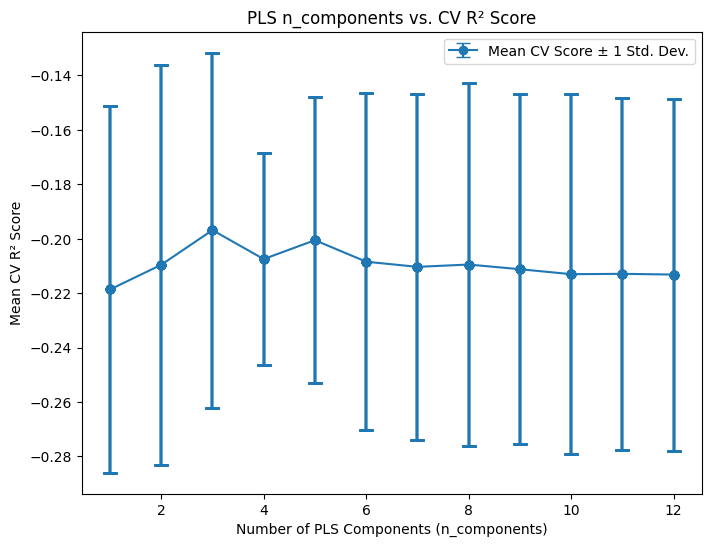

Best n_components: 3
Best cross-validation score: -0.1969


In [39]:

# Get the cross-validation results as a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Sort rows by n_components (sometimes helpful for clean plotting)
results = results.sort_values(by='param_n_components')

# Extract the parameter values, mean test score, and std test score
n_comps = results['param_n_components']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

# Plot mean CV score against n_components
plt.figure(figsize=(8, 6))
plt.errorbar(
    n_comps,
    mean_scores,
    yerr=std_scores,
    fmt='-o',
    capsize=5,
    label='Mean CV Score ± 1 Std. Dev.'
)
plt.xlabel('Number of PLS Components (n_components)')
plt.ylabel('Mean CV R² Score')
plt.title('PLS n_components vs. CV R² Score')
plt.legend()
plt.show()

print(f"Best n_components: {grid_search.best_params_['n_components']}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

In [40]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_n_components,param_tol,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021779,0.005954,0.014257,0.002114,500,1,1.000000e-09,"{'max_iter': 500, 'n_components': 1, 'tol': 1e...",-0.30053,-0.353659,...,-0.171400,-0.217423,-0.234744,-0.224377,-0.113318,-0.151050,-0.241662,-0.218689,0.067265,221
64,0.029385,0.010616,0.022051,0.012302,1000,1,1.000000e-13,"{'max_iter': 1000, 'n_components': 1, 'tol': 1...",-0.30053,-0.353659,...,-0.171400,-0.217423,-0.234744,-0.224377,-0.113318,-0.151050,-0.241662,-0.218689,0.067265,221
63,0.043390,0.016879,0.024180,0.009341,1000,1,1.000000e-12,"{'max_iter': 1000, 'n_components': 1, 'tol': 1...",-0.30053,-0.353659,...,-0.171400,-0.217423,-0.234744,-0.224377,-0.113318,-0.151050,-0.241662,-0.218689,0.067265,221
62,0.050089,0.032095,0.020129,0.012290,1000,1,1.000000e-11,"{'max_iter': 1000, 'n_components': 1, 'tol': 1...",-0.30053,-0.353659,...,-0.171400,-0.217423,-0.234744,-0.224377,-0.113318,-0.151050,-0.241662,-0.218689,0.067265,221
61,0.030189,0.010107,0.021754,0.010792,1000,1,1.000000e-10,"{'max_iter': 1000, 'n_components': 1, 'tol': 1...",-0.30053,-0.353659,...,-0.171400,-0.217423,-0.234744,-0.224377,-0.113318,-0.151050,-0.241662,-0.218689,0.067265,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.084960,0.029033,0.016218,0.006021,500,12,1.000000e-11,"{'max_iter': 500, 'n_components': 12, 'tol': 1...",-0.23002,-0.289550,...,-0.158326,-0.351502,-0.239417,-0.203488,-0.131918,-0.172928,-0.145811,-0.213202,0.064668,201
56,0.098406,0.025642,0.019918,0.009142,500,12,1.000000e-10,"{'max_iter': 500, 'n_components': 12, 'tol': 1...",-0.23002,-0.289550,...,-0.158326,-0.351502,-0.239417,-0.203488,-0.131918,-0.172928,-0.145811,-0.213202,0.064668,201
55,0.112147,0.045186,0.029737,0.029150,500,12,1.000000e-09,"{'max_iter': 500, 'n_components': 12, 'tol': 1...",-0.23002,-0.289550,...,-0.158326,-0.351502,-0.239417,-0.203488,-0.131918,-0.172928,-0.145811,-0.213202,0.064668,201
179,0.106787,0.026722,0.022008,0.009519,5000,12,1.000000e-13,"{'max_iter': 5000, 'n_components': 12, 'tol': ...",-0.23002,-0.289550,...,-0.158326,-0.351502,-0.239417,-0.203488,-0.131918,-0.172928,-0.145811,-0.213202,0.064668,201


In [41]:
# Identify columns like 'split0_test_score', 'split1_test_score', etc.
split_columns = [col for col in results.columns
                 if col.startswith('split') and col.endswith('_test_score')]

# Count how many folds each n_components "wins"
fold_wins = {nc: 0 for nc in param_grid['n_components']}
n_folds = len(split_columns)

for fold_col in split_columns:
    # idx of param setting with the best score in this particular fold
    best_idx = results[fold_col].idxmax()
    # The winning n_components for this fold
    best_nc = results.loc[best_idx, 'param_n_components']
    fold_wins[best_nc] += 1

# Convert counts to proportions (fold_wins[ nc ] / number_of_folds)
win_proportions = {nc: fold_wins[nc] / n_folds for nc in fold_wins}

# Reorder these proportions to match the order of n_comps in 'results'
proportions_ordered = [win_proportions[nc] for nc in n_comps]

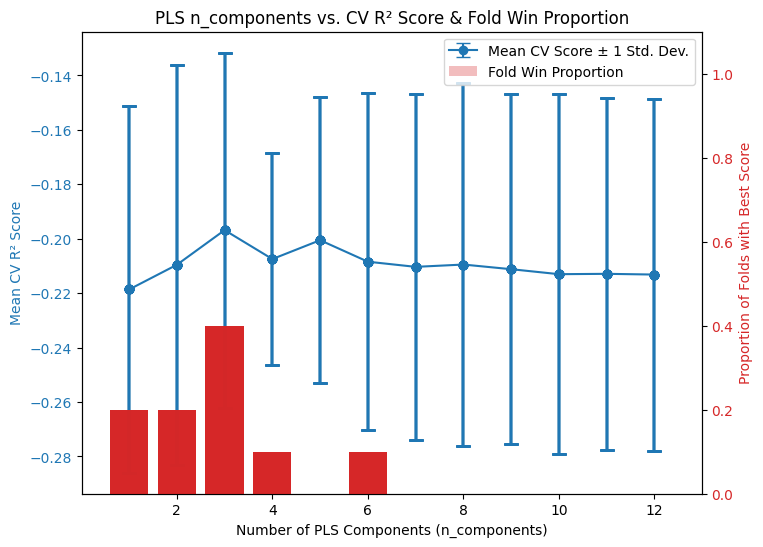

In [42]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# 1) Left axis: Mean CV R^2 with error bars
color_left = 'tab:blue'
ax1.errorbar(
    n_comps,
    mean_scores,
    yerr=std_scores,
    fmt='-o',
    capsize=5,
    color=color_left,
    label='Mean CV Score ± 1 Std. Dev.'
)
ax1.set_xlabel('Number of PLS Components (n_components)')
ax1.set_ylabel('Mean CV R² Score', color=color_left)
ax1.tick_params(axis='y', labelcolor=color_left)

# 2) Right axis: Bar chart of "proportion of folds with best score"
ax2 = ax1.twinx()  # create a twin Axes sharing the x-axis
color_right = 'tab:red'

# Bar chart
ax2.bar(
    n_comps,
    proportions_ordered,
    color=color_right,
    alpha=0.3,       # slightly transparent so we can see the line behind
    label='Fold Win Proportion'
)
ax2.set_ylabel('Proportion of Folds with Best Score', color=color_right)
ax2.tick_params(axis='y', labelcolor=color_right)
ax2.set_ylim(0, 1.1)  # ensure space above the tallest bar

# Combine legends from both axes, if desired
lines_labels_1 = ax1.get_legend_handles_labels()
lines_labels_2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines_labels_1[0] + lines_labels_2[0],
    lines_labels_1[1] + lines_labels_2[1],
    loc='best'
)

plt.title('PLS n_components vs. CV R² Score & Fold Win Proportion')
plt.show()


In [43]:
pls.get_params()

{'copy': True, 'max_iter': 500, 'n_components': 2, 'scale': True, 'tol': 1e-06}